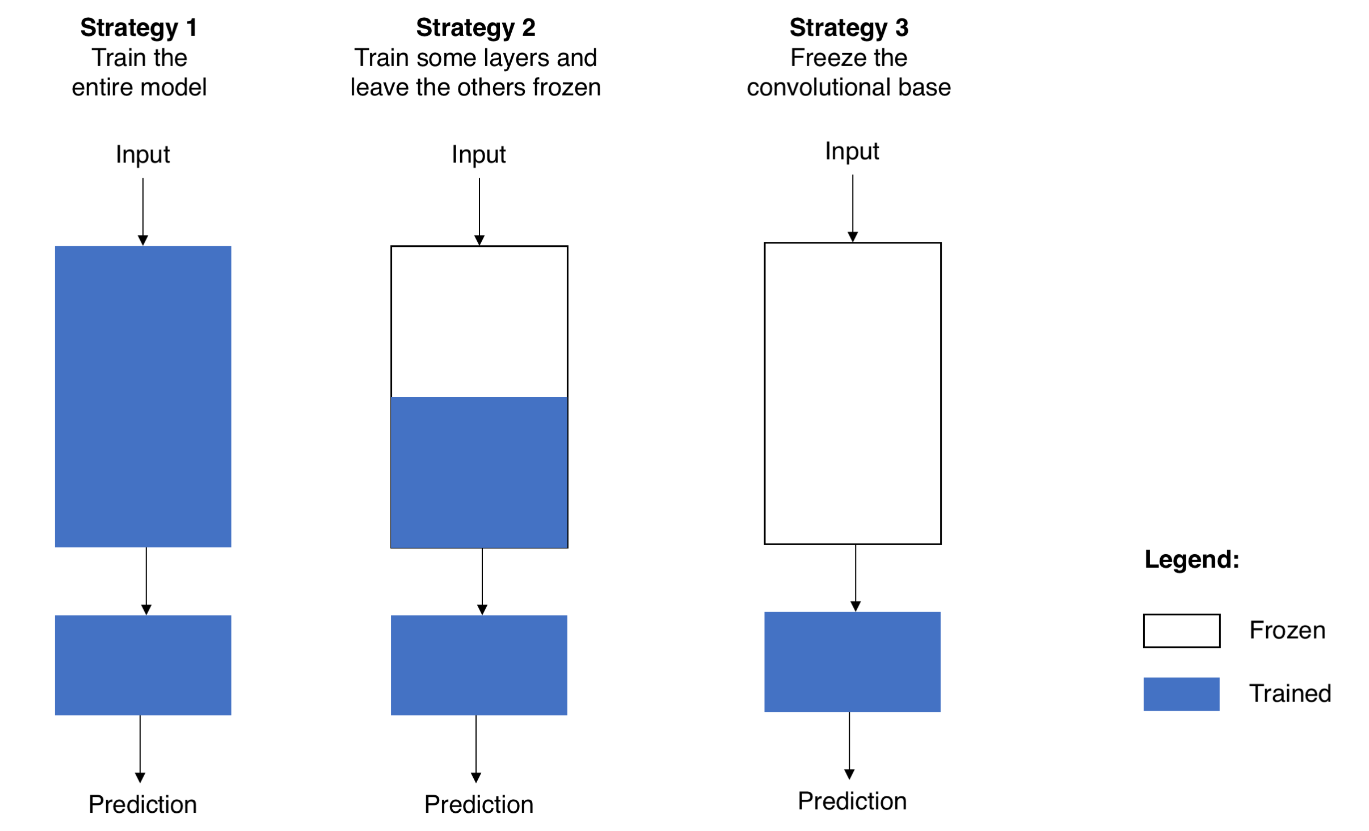

In [1]:
from IPython.display import Image
Image("strategies.png")

In this notebook we apply Strategy 3, i.e., freeze the convolutional base. In other words, you just need to remove the last-fully connected (output-layer), run the pre-trained model as a fixed feature extractor, and the use the resulting features to train a new classifier.

This technique is indicated when dataset is small and similar to the pre-trained model dataset.

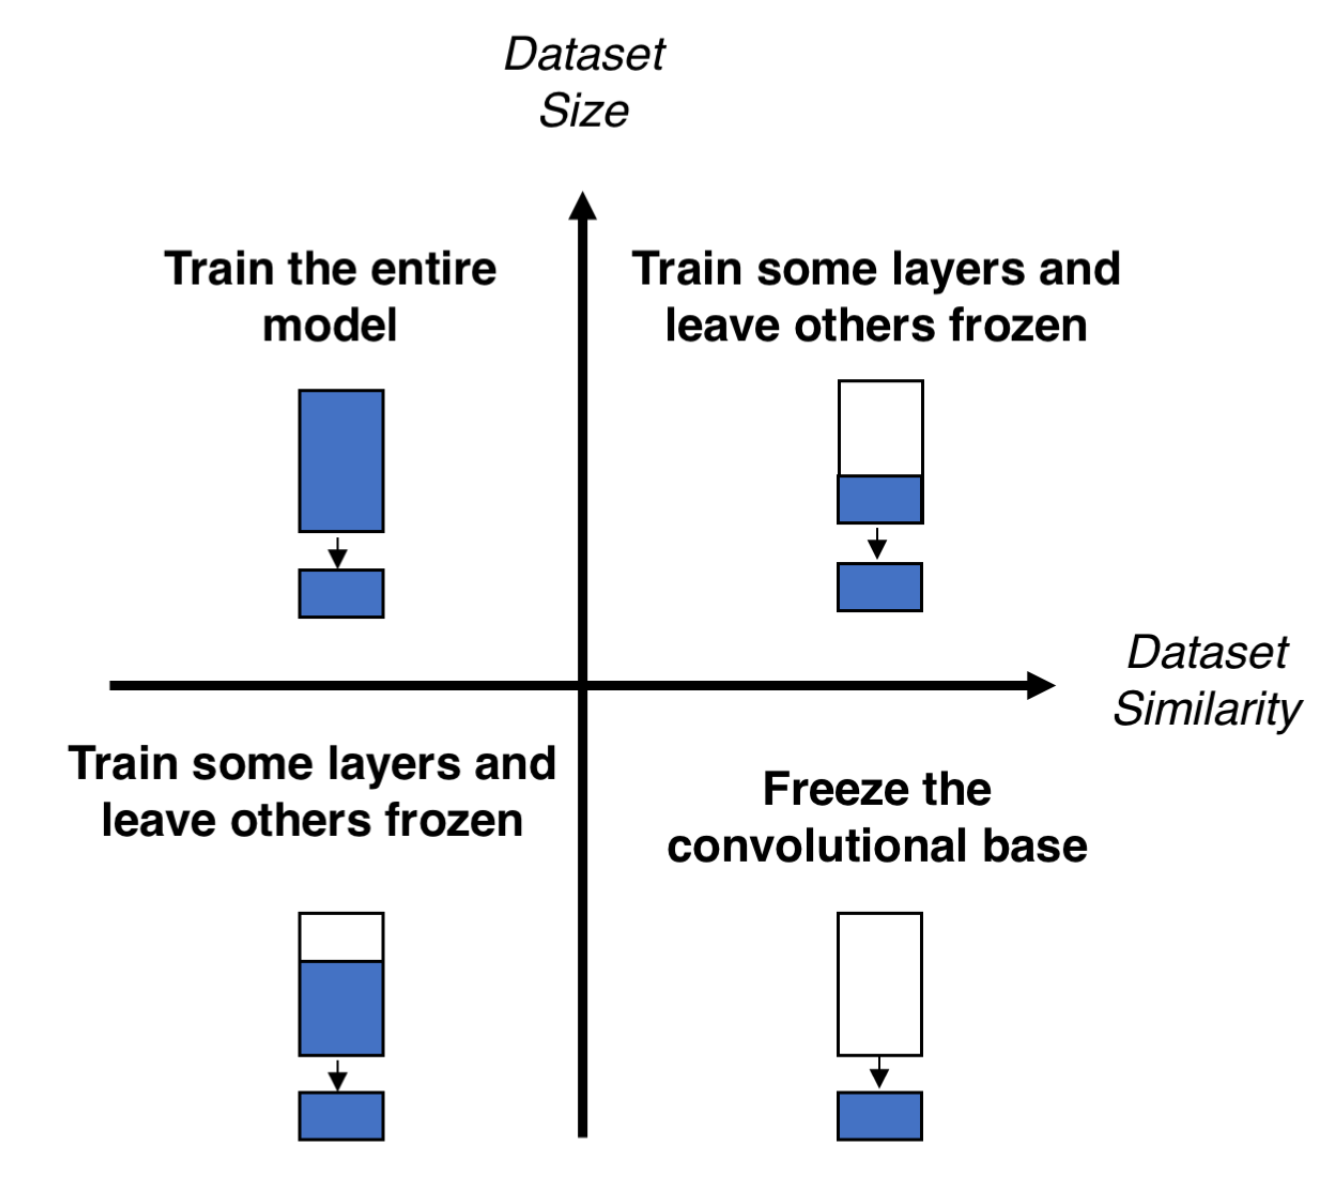

In [2]:
from IPython.display import Image
Image("approaches.png")

# Extract features from the convolutional base

In [3]:
img_width, img_height, img_channels = 128, 128, 3  # Default input size for VGG19 is 224, 224

In [4]:
# Instantiate convolutional base
from keras.applications import VGG19

conv_base = VGG19(weights='imagenet', 
                  include_top=False, #false means that we want to train our own classifier on top of the convolutional base.
                  input_shape=(img_width, img_height, 3))  # 3 = number of channels in RGB pictures

Using TensorFlow backend.


In [5]:
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [6]:
conv_base.output_shape

(None, 4, 4, 512)

Now that we have the convolutional base, we need to pass our images through it for feature extraction. 

Here is used the cheaper solution, i.e., running the convolutional base over the dataset, recording its output to a
Numpy array on disk, and then using this data as input to a standalone, classifier. This solution it is not possible to use data augmetation. In another notebook we will use the technique of feature extraction that does allow using data augmentation.

In [7]:
import os

base_dir = "../data/TTG_TUR/"
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')
train_SIM_dir = os.path.join(train_dir, 'SIM')
train_NAO_dir = os.path.join(train_dir, 'NAO')
validation_SIM_dir = os.path.join(validation_dir, 'SIM')
validation_NAO_dir = os.path.join(validation_dir, 'NAO')
test_SIM_dir = os.path.join(test_dir, 'SIM')
test_NAO_dir = os.path.join(test_dir, 'NAO')

In [8]:
def count_files_in_directory(path):
    
    fileslist = []
    for root, dirs, files in os.walk(path):
        for filename in files:
            fileslist.append(filename)
            
    return len(fileslist)

In [9]:
files_train = count_files_in_directory(train_dir)
files_validation = count_files_in_directory(validation_dir)
files_test = count_files_in_directory(test_dir)

In [10]:
print(files_train, files_validation, files_test)

5061 632 632


In [11]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, conv_base.output_shape[1], 
                               conv_base.output_shape[2], conv_base.output_shape[3]))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary')

    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, files_train)
validation_features, validation_labels = extract_features(validation_dir, files_validation)
test_features, test_labels = extract_features(test_dir, files_test)

Found 5061 images belonging to 2 classes.
Found 632 images belonging to 2 classes.
Found 632 images belonging to 2 classes.


In [12]:
train_features.shape

(5061, 4, 4, 512)

In [13]:
input_dim = train_features.shape[1] * train_features.shape[2] * train_features.shape[3]

In [14]:
input_dim

8192

# Classifiers

## Fully connected layers

### Modeling

This classifier adds a stack of fully-connected layers that is fed by the features extracted from the convolutional base.

In [15]:
# Define model

from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Flatten(input_shape=(conv_base.output_shape[1], conv_base.output_shape[2], 
                                      conv_base.output_shape[3])))
model.add(layers.Dense(256, activation='relu', input_dim=input_dim))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


### Compile model

In [16]:
# Compile model

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

### Train model

The model is trained using the features extracted in the conv_base.

In [17]:
import datetime

# print(datetime.datetime.now())
t1 = datetime.datetime.now()
print(t1)

2019-11-26 09:15:22.173776


In [18]:
# Train model

epochs = 30
batch_size = 20

# Using EarlyStopping

# Import EarlyStopping
from keras.callbacks import EarlyStopping

# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=3)

history = model.fit(train_features, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_features, validation_labels),
                   class_weight = 'auto',
                   callbacks=[early_stopping_monitor])

Train on 5061 samples, validate on 632 samples
Epoch 1/30
5061/5061 [==============================] - 7s 1ms/step - loss: 0.5545 - acc: 0.7582 - val_loss: 0.5127 - val_acc: 0.7816
Epoch 2/30
5061/5061 [==============================] - 8s 2ms/step - loss: 0.5046 - acc: 0.7817 - val_loss: 0.5014 - val_acc: 0.7864
Epoch 3/30
5061/5061 [==============================] - 7s 1ms/step - loss: 0.4831 - acc: 0.7878 - val_loss: 0.4856 - val_acc: 0.7896
Epoch 4/30
5061/5061 [==============================] - 7s 1ms/step - loss: 0.4762 - acc: 0.7911 - val_loss: 0.4777 - val_acc: 0.8022
Epoch 5/30
5061/5061 [==============================] - 8s 2ms/step - loss: 0.4654 - acc: 0.7919 - val_loss: 0.4753 - val_acc: 0.8022
Epoch 6/30
5061/5061 [==============================] - 8s 1ms/step - loss: 0.4571 - acc: 0.7989 - val_loss: 0.4722 - val_acc: 0.7991
Epoch 7/30
5061/5061 [==============================] - 8s 2ms/step - loss: 0.4505 - acc: 0.8002 - val_loss: 0.4667 - val_acc: 0.8038
Epoch 8/30
5061

### Save model

In [19]:
# save model
model.save("../models/VGG19_firebreak_detection_feature_extraction_without_data_augmentation_FC_model.h5")

### Model evaluation

#### Learning curves

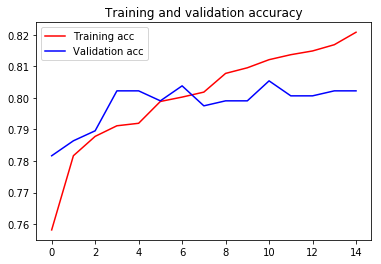

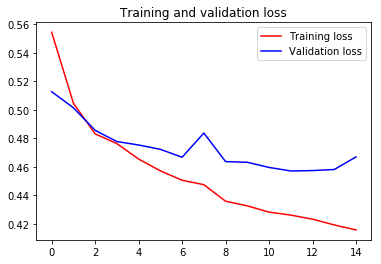

In [25]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [21]:
# create a dataframe to save the result as .csv
import pandas as pd

df = pd.DataFrame(history.history)

df.to_csv("../models/VGG19_firebreak_detection_feature_extraction_without_data_augmentation_FC_history.csv", index = False)

In [22]:
t2 = datetime.datetime.now()
(print(t2))
print(t2-t1)

2019-11-26 09:17:15.346821
0:01:53.173045


#### Model in action

In [23]:
# Define function to visualize predictions
import random
from keras.preprocessing import image

def visualize_predictions(classifier, n_cases):
    for i in range(0,n_cases):
        path = random.choice([test_NAO_dir, test_SIM_dir])

        # Get picture
        random_img = random.choice(os.listdir(path))
        img_path = os.path.join(path, random_img)
        img = image.load_img(img_path, target_size=(img_width, img_height))
        img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
        img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application

        # Extract features
        features = conv_base.predict(img_tensor.reshape(1,img_width, img_height, 3))

        # Make prediction
        try:
            prediction = classifier.predict(features)
        except:
            prediction = classifier.predict(features.reshape(1, input_dim))

        # Show picture
        plt.imshow(img_tensor)
        plt.show()

        # Write prediction
        if prediction < 0.5:
            print(random_img)
            print('Not firebreack')
        else:
            print(random_img)
            print('Firebreak')

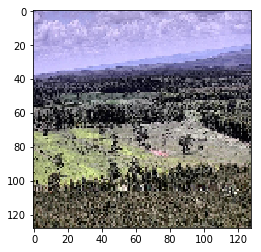

2018-03-18 12-07-36_NAO.jpeg
Not firebreack


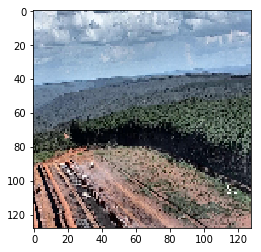

2018-03-18 16-01-14_NAO.jpeg
Not firebreack


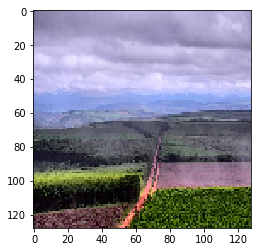

2018-12-12 09-18-43_SIM.jpeg
Firebreak


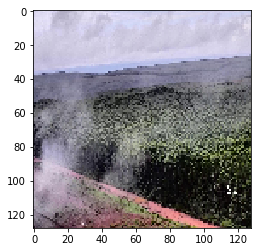

2018-02-26 09-24-57_SIM.jpeg
Not firebreack


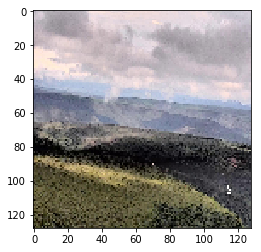

2018-02-24 08-47-24_SIM.jpeg
Not firebreack


In [24]:
# Visualize predictions
visualize_predictions(model, 5)

## Global average pooling

The data is used as previously. We will just use the features extracted from the convolutional base to feed the classifier.

### Modeling

Instead of adding a stack of fully-connected layers, as before, we will add a global average pooling layer and fed its output into a sigmoid activated layer.

Note that we are talking about a sigmoid activated layers instead of a softmax one, which is what is recommended by [Lin et al. (2013)](https://arxiv.org/pdf/1312.4400.pdf). We are changing to the sigmoid activation because in Keras, to perform binary classification, you should use sigmoid activation and binary_crossentropy as the loss (see Chollet's book). Accordingly, it was necessary to do this small modification to the original proposal of Lin et al. (2013).

In [26]:
#Define model

from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.GlobalAveragePooling2D(input_shape=(conv_base.output_shape[1], conv_base.output_shape[2], conv_base.output_shape[3])))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________


### Compile Model

In [27]:
model.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['acc'])

### Train model

In [28]:
# Train model

epochs=30
batch_size=20

history = model.fit(train_features, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_features, validation_labels),
                   class_weight = 'auto',
                   callbacks=[early_stopping_monitor])

Train on 5061 samples, validate on 632 samples
Epoch 1/30
5061/5061 [==============================] - 1s 170us/step - loss: 0.5539 - acc: 0.7459 - val_loss: 0.5327 - val_acc: 0.7627
Epoch 2/30
5061/5061 [==============================] - 1s 142us/step - loss: 0.5180 - acc: 0.7647 - val_loss: 0.5231 - val_acc: 0.7848
Epoch 3/30
5061/5061 [==============================] - 1s 140us/step - loss: 0.5070 - acc: 0.7742 - val_loss: 0.5117 - val_acc: 0.7864
Epoch 4/30
5061/5061 [==============================] - 1s 138us/step - loss: 0.4996 - acc: 0.7811 - val_loss: 0.5082 - val_acc: 0.7864
Epoch 5/30
5061/5061 [==============================] - 1s 127us/step - loss: 0.4948 - acc: 0.7842 - val_loss: 0.5039 - val_acc: 0.7864
Epoch 6/30
5061/5061 [==============================] - 1s 131us/step - loss: 0.4906 - acc: 0.7862 - val_loss: 0.5007 - val_acc: 0.7848
Epoch 7/30
5061/5061 [==============================] - 1s 140us/step - loss: 0.4874 - acc: 0.7872 - val_loss: 0.4993 - val_acc: 0.7769
E

### Save model

In [29]:
# save model
model.save("../models/VGG19_firebreak_detection_feature_extraction_without_data_augmentation_GAP_model.h5")

### Model evaluation

#### Learning curves

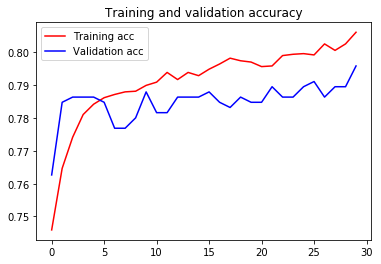

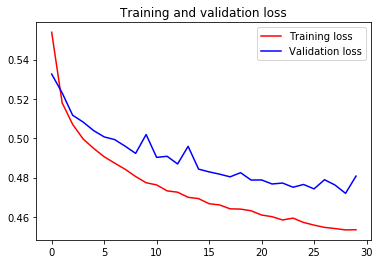

In [30]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [31]:
# create a dataframe to save the result as .csv
import pandas as pd

df = pd.DataFrame(history.history)

df.to_csv("../models/VGG19_firebreak_detection_feature_extraction_without_data_augmentation_GAP_history.csv", index = False)

In [32]:
t3 = datetime.datetime.now()
(print(t3))
print(t3-t2)

2019-11-26 09:20:24.667065
0:03:09.320244


#### Model in action

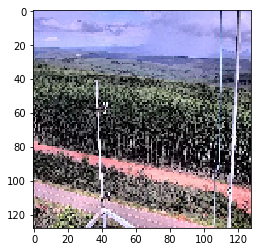

2018-03-04 09-01-53_NAO.jpeg
Not firebreack


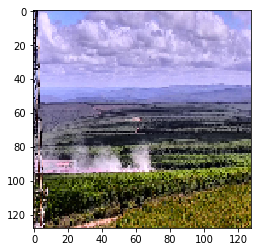

2019-01-30 10-16-53_NAO.jpeg
Firebreak


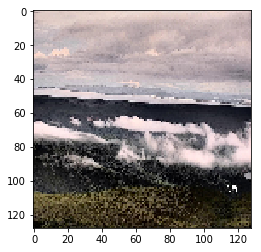

2018-03-08 06-37-25_NAO.jpeg
Not firebreack


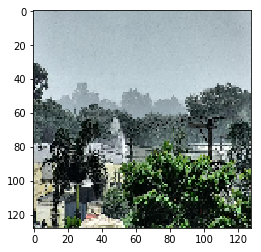

2018-01-30 15-54-02_SIM.jpeg
Firebreak


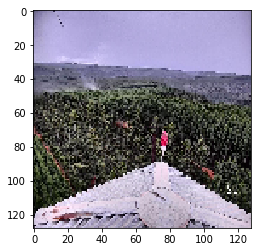

2018-03-17 14-59-33_SIM.jpeg
Firebreak


In [33]:
# Visualize predictions
visualize_predictions(model, 5)

**REFERENCES:**

https://towardsdatascience.com/transfer-learning-from-pre-trained-models-f2393f124751

https://github.com/fchollet/deep-learning-with-python-notebooks